# Swiss Road Safety Analysis: Focus on Elderly Road Users (2014–2023)

## Research Objective

This notebook analyzes Swiss road accident statistics (SVU data, 2014–2023) with a specific focus on elderly people (seniors aged 65+). We investigate how accident patterns, severity, and contributing factors differ across age groups, with particular attention to senior drivers, pedestrians, and cyclists.

**Key research questions:**
- How do roles in traffic (driver, passenger, pedestrian, cyclist) differ by age group?
- What are the most common accident types involving seniors?
- How do environmental conditions (weather, road conditions, lighting, urban/rural) affect accident severity for elderly people?
- When (time of day, year) do accidents involving seniors most frequently occur?
- Are there regional (canton) differences in accidents involving seniors?

**Dataset:** Official Swiss accident statistics (SVU 2014–2023) with person-level and accident-level data.

**Age groups:** We focus on three main groups: 0–19 (youth), 20–64 (adults), and 65+ (seniors), with additional sub-analysis of 65–69, 70–74, and 75+ where relevant.

## 1. Setup: Importing Libraries and Loading Data

We begin by importing necessary libraries for data manipulation (pandas), visualization (matplotlib, seaborn), and numerical operations (numpy).

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")

### Configuration Constants

Define analysis parameters and color schemes for consistent visualization throughout the notebook.

In [25]:
# Analysis configuration constants
AGE_BINS = [0, 19, 64, 150]
AGE_LABELS = ["0-19", "20-64", "65+"]
SENIOR_AGE_THRESHOLD = 65

# Number of top items to show in various plots
TOP_N_ROLES = 5
TOP_N_ACCIDENT_TYPES = 8
TOP_N_CANTONS = 10

# Color palette for consistent visualization
COLOR_PALETTE = {
    'adults_20_64': '#4C72B0',      # blue
    'seniors_65plus': '#DD8452',    # orange
    'age_65_69': '#A9A9A9',         # grey
    'age_70_74': '#008080',         # teal
    'age_75plus': '#FFA500',        # orange
    'youth_0_19': '#55A868',        # green
}

# Plot styling defaults
PLOT_STYLE = {
    'edgecolor': 'black',
    'linewidth': 0.6
}

# Severity group mapping for Unfallfolgen [accident consequences]
# Maps 8 original injury categories into 3 simplified severity groups
SEVERITY_MAPPING = {
    "nicht verletzt": "nicht / leicht verletzt / unbekannt",          # not injured
    "leicht verletzt": "nicht / leicht verletzt / unbekannt",         # slightly injured
    "unbekannt": "nicht / leicht verletzt / unbekannt",               # unknown
    "schwer verletzt (vor 2015)": "erheblich / schwer verletzt",      # severely injured (pre-2015)
    "erheblich verletzt": "erheblich / schwer verletzt",              # severely injured
    "auf Platz gestorben": "lebensdrohlich / tödlich",                # died on scene
    "innert 30 Tagen gestorben": "lebensdrohlich / tödlich",          # died within 30 days
    "lebensdrohlich verletzt": "lebensdrohlich / tödlich"             # life-threatening injuries
}

### Helper Functions

Utility functions for data filtering, processing, and abbreviating long German labels for plots.

In [26]:
def filter_by_age_group(df, age_col='Alter', min_age=None, max_age=None, age_group=None):
    """
    Filter dataframe by age criteria.
    
    Parameters:
    - df: DataFrame to filter
    - age_col: Name of age column (default: 'Alter')
    - min_age: Minimum age (inclusive)
    - max_age: Maximum age (inclusive)
    - age_group: Alternative - use age_group column value (e.g., '65+')
    
    Returns: Filtered DataFrame
    """
    if age_group is not None:
        return df[df['age_group'] == age_group].copy()
    elif min_age is not None and max_age is not None:
        return df[(df[age_col] >= min_age) & (df[age_col] <= max_age)].copy()
    elif min_age is not None:
        return df[df[age_col] >= min_age].copy()
    else:
        return df.copy()


def calculate_group_percentages(df, group_col, value_col):
    """
    Calculate percentages within groups.
    
    Parameters:
    - df: DataFrame
    - group_col: Column to group by
    - value_col: Column to count
    
    Returns: DataFrame with counts and percentages
    """
    counts = df.groupby([group_col, value_col]).size().reset_index(name='count')
    counts['percentage'] = counts.groupby(group_col)['count'].transform(lambda x: x / x.sum() * 100)
    return counts


def abbreviate_label(text, max_length=40):
    """
    Abbreviate long German accident type labels for plot readability.
    
    Parameters:
    - text: Original German label
    - max_length: Maximum length before abbreviation
    
    Returns: Abbreviated label with number indicator
    """
    # Convert to string and handle NaN/None
    if pd.isna(text):
        return "Unbekannt"
    text = str(text)
    
    # Common abbreviations for Swiss German accident terminology
    abbreviations = {
        'Abbiegeunfall': 'Abbiegen',
        'Einbiegeunfall': 'Einbiegen',
        'Überholunfall oder Fahrstreifenwechsel': 'Überholen/Spurwechsel',
        'Fussgängerunfall': 'Fussgänger',
        'Auffahrunfall': 'Auffahren',
        'Schleuder- oder Selbstunfall': 'Schleudern/Selbst',
        'Überfahrunfall': 'Überfahren',
        'Frontalkollision': 'Frontal',
        'Parkierunfall': 'Parkieren',
    }
    
    for full, abbrev in abbreviations.items():
        if full in text:
            text = text.replace(full, abbrev)
    
    if len(text) > max_length:
        return text[:max_length-3] + '...'
    return text


def create_accident_type_abbreviations(unique_types):
    """
    Create a mapping of full accident type names to short abbreviations with numbers.
    
    Parameters:
    - unique_types: List or array of unique accident type labels
    
    Returns: Dictionary mapping full names to 'T1: ShortName', 'T2: ShortName', etc.
    """
    mapping = {}
    for idx, type_name in enumerate(unique_types, start=1):
        short_name = abbreviate_label(type_name, max_length=25)
        mapping[type_name] = f"T{idx}: {short_name}"
    return mapping

### Load Dataset

Load the Swiss accident statistics dataset (SVU 2014–2023). The data is stored in CSV format with Latin-1 encoding.

In [27]:
file_path = "/Users/alina/Downloads/2025_Vorlesung-SVS_Hausarbeit_Daten/svu14-23.csv"
df = pd.read_csv(file_path, encoding='latin1', delimiter=',')

In [55]:
df.columns.tolist()

Total columns: 132

All column names:
  1. UnfallUID
  2. EreignisOID
  3. Quelle
  4. Unfalljahr
  5. Unfalldatum
  6. Unfallzeit
  7. Unfallmonat
  8. Feiertag
  9. Unfallkanton
 10. EreignisTotalBeteiligte
 11. EreignisTotalObjekte
 12. EreignisTotalPersonen
 13. Unfalltypengruppe
 14. Unfalltyp
 15. Sachschaden
 16. Hauptursachengruppe
 17. Hauptursachenuntergruppe
 18. Hauptursache
 19. InnerortsAusserorts
 20. Ortslage
 21. xKoordinate
 22. yKoordinate
 23. Autobahnname
 24. Gemeindenummer
 25. GemeindeText
 26. Ortschaft
 27. Strassenart
 28. StrassenartZusatz_1
 29. StrassenartZusatz_2
 30. StrassenartZusatz_3
 31. Strassenkategorie
 32. Zonensignalisation
 33. Höchstgeschwindigkeit
 34. HöchstgeschwindigkeitZusatz_1
 35. HöchstgeschwindigkeitZusatz_2
 36. Unfallstelle
 37. UnfallstelleZusatz_1
 38. UnfallstelleZusatz_2
 39. UnfallstelleZusatz_3
 40. UnfallstelleZusatz_4
 41. UnfallstelleZusatz_5
 42. UnfallstelleZusatz_6
 43. Vortrittsregelung
 44. VortrittsregelungZusatz_1
 4

In [56]:
# Display data with all columns visible
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 10)

# Taking a first glance at data - showing first 5 rows with all columns
df.head(5)

,UnfallUID,EreignisOID,Quelle,Unfalljahr,Unfalldatum,Unfallzeit,Unfallmonat,Feiertag,Unfallkanton,EreignisTotalBeteiligte,EreignisTotalObjekte,EreignisTotalPersonen,Unfalltypengruppe,Unfalltyp,Sachschaden,Hauptursachengruppe,Hauptursachenuntergruppe,Hauptursache,InnerortsAusserorts,Ortslage,xKoordinate,yKoordinate,Autobahnname,Gemeindenummer,GemeindeText,Ortschaft,Strassenart,StrassenartZusatz_1,StrassenartZusatz_2,StrassenartZusatz_3,Strassenkategorie,Zonensignalisation,Höchstgeschwindigkeit,HöchstgeschwindigkeitZusatz_1,HöchstgeschwindigkeitZusatz_2,Unfallstelle,UnfallstelleZusatz_1,UnfallstelleZusatz_2,UnfallstelleZusatz_3,UnfallstelleZusatz_4,UnfallstelleZusatz_5,UnfallstelleZusatz_6,Vortrittsregelung,VortrittsregelungZusatz_1,VortrittsregelungZusatz_2,Verkehrsaufkommen,Witterung,Witterungzusatz_1,Witterungzusatz_2,Strassenzustand,Strassenbeleuchtung,Lichtverhältnis,ObjektUID,ObjektOID,ObjektTotalPersonen,ObjektKategorie,Hauptverursacher,Ursachengruppe_1,Ursachengruppe_2,Ursachengruppe_3,Ursachenuntergruppe_1,Ursachenuntergruppe_2,Ursachenuntergruppe_3,Ursache_1,Ursache_2,Ursache_3,Meldepflicht,Anprall_1,Anprall_2,Anprall_3,anprall_d,FAZ,Fahrzeugart,FahrzeugartZusatz,FahrzeugartZusatz_d,FahrzeugartWeitere,Fahrzeugmarke,Fahrzeugtyp,FahrzeugInverkehrsetzung,FahrzeugLeistungKW,Fahrzeuggewicht,FahrzeugHubraum,FahrzeugSitzplätze,Fahrzeugfarbe,Anhänger,KontrollschildKanton,KontrollschildLand,KontrollschildLandText,KontrollschildFarbe,Verkehrsteilnahme,Verkehrsteilnahme_d,Verkehrsteilnahme_dd,Verkehrsteilnahme_ASTRA,Fahrzweck,AngabeFührerausweis,AngabeFührerausweisZusatz_1,AngabeFührerausweisZusatz_2,AngabeFührerausweisZusatz_3,FührerausweisLand,FührerausweisLandText,FührerausweisKategorie,FührerausweisDatum,Führerausweisalter,Atemalkoholprobe,AtemalkoholprobeZusatz,AtemalkoholErgebnis,BlutprobeAlkohol,BlutprobeAlkoholZusatz,BlutalkoholErgebnis,BlutUrinprobeAM,BlutUrinprobeAMZusatz,BlutUrinprobeAMErgebnis,BlutUrinprobeBTM,BlutUrinprobeBTMZusatz,BlutUrinprobeBTMErgebnis,PersonUID,PersonenOID,PersonNr,Personenart,PersonenartZusatz,Geburtsdatum,Alter,Geschlecht,Nationalität,NationalitätText,Wohnland,WohnlandText,Unfallfolgen,NACA,Todesdatum,Schutzsystem,SchutzsystemZusatz
0,000632B7E4500082E0530A83942743EA,20141552076,Bern,2014,7/12/2014,22:10:00,Juli,0,BE,2,2,2,4,Kollision beim Rechtseinbiegen mit von links kommendem Fahrzeug,2.5,2,23,Missachten des Vortrittssignals Kein Vortritt,innerorts,1,647210.0,177439.0,,573,Brienz (BE),Brienz,Hauptstrasse,ohne Eintrag,ohne Eintrag,ohne Eintrag,Kantonsstrasse,keine,50,ohne Eintrag,ohne Eintrag,Verzweigung,ohne Eintrag,ohne Eintrag,ohne Eintrag,ohne Eintrag,ohne Eintrag,ohne Eintrag,Signal ''Kein Vortritt'',ohne Eintrag,ohne Eintrag,schwach,Regen,ohne Eintrag,ohne Eintrag,nass,in Betrieb,Nacht,000632B7E46C0082E0530A83942743EA,20142626246,1,Fahrzeug,ja,2,ohne Eintrag,ohne Eintrag,23,ohne Eintrag,ohne Eintrag,Missachten des Vortrittssignals Kein Vortritt,ohne Eintrag,ohne Eintrag,653,ohne Eintrag,ohne Eintrag,ohne Eintrag,ohne Eintrag,001 Personenwagen,Personenwagen,ohne Eintrag,ohne Eintrag,,,,7/20/2010,ohne Eintrag,,ohne Eintrag,ohne Eintrag,Schwarz,nein,Bern,Schweiz,Schweiz,weiss Motorwagen,Personenwagen,Personenwagen,Personenwagen,Personenwagen,Freizeit / Einkauf,definitiver Führerausweis,ohne Eintrag,ohne Eintrag,,Schweiz,Schweiz,B,6/15/1984,30,nicht angeordnet,ohne Eintrag,ohne Eintrag,nicht angeordnet,ohne Eintrag,ohne Eintrag,nicht angeordnet,ohne Eintrag,ohne Eintrag,nicht angeordnet,ohne Eintrag,ohne Eintrag,000632B7E46F0082E0530A83942743EA,20143266564,1,Lenker/in,Halter/in des Fahrzeugs,4/24/1963,51,Weiblich,Schweiz,Schweiz,Schweiz,Schweiz,nicht verletzt,ohne Eintrag,,Sicherheitsgurt,ohne Eintrag
1,000632B7E4500082E0530A83942743EA,20141552076,Bern,2014,7/12/2014,22:10:00,Juli,0,BE,2,2,2,4,Kollision beim Rechtseinbiegen mit von links kommendem Fahrzeug,2.5,2,23,Missachten des Vortrittssignals Kein Vortritt,innerorts,1,647210.0,177439.0,,573,Brienz (BE),Brienz,Hauptstrasse,ohne Eintrag,

In [30]:
print("Shape of full dataset:", df.shape)

Shape of full dataset: (1060554, 132)


## 2. Data Exploration and Column Selection

Inspect the dataset structure and select relevant columns for analysis. We focus on accident-level attributes (date, location, type, conditions), object/participation data (vehicle type, responsibility), and person-level information (age, gender, injury severity).

In [58]:
# keeping only relevant columns
cols_keep = [
    # Accident level
    "UnfallUID",            # accident ID
    "Unfalljahr",           # accident year
    "Unfalldatum",          # accident date
    "Unfallzeit",           # accident time
    "Unfallmonat",          # accident month
    "Unfallkanton",         # accident canton
    "Unfalltypengruppe",    # accident type group
    "Unfalltyp",            # detailed accident type
    "InnerortsAusserorts",  # urban / non-urban
    "Verkehrsaufkommen",    # traffic volume
    "Witterung",            # weather
    "Strassenzustand",      # road condition
    "Strassenbeleuchtung",  # street lighting
    "Lichtverhältnis",      # light conditions

    # Object / participation
    "ObjektUID",            # object UID
    "ObjektKategorie",      # object category
    "Fahrzeugart",          # vehicle type
    "Verkehrsteilnahme",    # mode of participation
    "Fahrzweck",            # trip purpose
    "Hauptverursacher",     # main responsible (ja/nein)

    # Person level
    "PersonUID",            # person UID
    "PersonenOID",          # person OID
    "Personenart",          # person type: Lenker/in (driver), Mitfahrer/in (passenger), etc.
    "PersonenartZusatz",    # person type - additional info
    "Alter",                # age
    "Geschlecht",           # gender
    "Unfallfolgen",         # accident consequences
    "NACA"                  # injury severity index
]
existing_cols = [c for c in cols_keep if c in df.columns]

df_filt = df[cols_keep]
print("Columns in df_filt:", df_filt.columns.tolist())
print("Shape of df_filt:", df_filt.shape)

Columns in df_filt: ['UnfallUID', 'Unfalljahr', 'Unfalldatum', 'Unfallzeit', 'Unfallmonat', 'Unfallkanton', 'Unfalltypengruppe', 'Unfalltyp', 'InnerortsAusserorts', 'Verkehrsaufkommen', 'Witterung', 'Strassenzustand', 'Strassenbeleuchtung', 'Lichtverhältnis', 'ObjektUID', 'ObjektKategorie', 'Fahrzeugart', 'Verkehrsteilnahme', 'Fahrzweck', 'Hauptverursacher', 'PersonUID', 'PersonenOID', 'Personenart', 'PersonenartZusatz', 'Alter', 'Geschlecht', 'Unfallfolgen', 'NACA']
Shape of df_filt: (1060554, 28)


In [32]:
df_filt.head()

,UnfallUID,Unfalljahr,Unfalldatum,Unfallzeit,Unfallmonat,Unfallkanton,Unfalltypengruppe,InnerortsAusserorts,Verkehrsaufkommen,Witterung,...,Fahrzweck,Hauptverursacher,PersonUID,PersonenOID,Personenart,PersonenartZusatz,Alter,Geschlecht,Unfallfolgen,NACA
0,000632B7E4500082E0530A83942743EA,2014,7/12/2014,22:10:00,Juli,BE,4,innerorts,schwach,Regen,...,Freizeit / Einkauf,ja,000632B7E46F0082E0530A83942743EA,20143266564,Lenker/in,Halter/in des Fahrzeugs,51,Weiblich,nicht verletzt,ohne Eintrag
1,000632B7E4500082E0530A83942743EA,2014,7/12/2014,22:10:00,Juli,BE,4,innerorts,schwach,Regen,...,Freizeit / Einkauf,nein,000632B7E49F0082E0530A83942743EA,20143266565,Lenker/in,Halter/in des Fahrzeugs,44,Männlich,schwer verletzt (vor 2015),ohne Eintrag
2,000750DA1C9B0038E0530A8394272B98,2014,7/23/2014,18:15:00,Juli,BE,1,innerorts,stark,bedeckt,...,Arbeitsweg,ja,000750DA1CBB0038E0530A8394272B98,20143266566,Lenker/in,Halter/in des Fahrzeugs,47,Weiblich,nicht verletzt,ohne Eintrag
3,000750DA1C9B0038E0530A8394272B98,2014,7/23/2014,18:15:00,Juli,BE,1,innerorts,stark,bedeckt,...,Freizeit / Einkauf,nein,000750DA1CEC0038E0530A8394272B98,20143266567,Lenker/in,ohne Eintrag,42,Männlich,nicht verletzt,ohne Eintrag
4,000750DA1E180038E0530A8394272B98,2014,6/25/2014,18:53:00,Juni,SG,7,innerorts,stark,bedeckt,...,unbekannt,ja,000750DA1E3B0038E0530A8394272B98,20143266568,Lenker/in,ohne Eintrag,ohne Eintrag,Weiblich,unbekannt,ohne Eintrag


In [59]:
# unique values --> take a look at any of those if you are interested in any specific column
df_filt["Unfallkanton"].unique()
df_filt["Unfalltypengruppe"].unique()
df_filt["Unfalltyp"].unique()
df_filt["Verkehrsaufkommen"].unique()
df_filt["Witterung"].unique()
df_filt["Strassenzustand"].unique()
df_filt["Strassenbeleuchtung"].unique()
df_filt["Lichtverhältnis"].unique()
df_filt["ObjektKategorie"].unique()
df_filt["Fahrzeugart"].unique()
df_filt["Verkehrsteilnahme"].unique()
df_filt["Fahrzweck"].unique()
df_filt["Personenart"].unique()
df_filt["NACA"].unique()
df_filt["Unfallfolgen"].unique()

array(['nicht verletzt', 'schwer verletzt (vor 2015)', 'unbekannt',
       'leicht verletzt', 'auf Platz gestorben',
       'innert 30 Tagen gestorben', 'erheblich verletzt',
       'lebensbedrohlich verletzt'], dtype=object)

## 3. Data Preparation and Feature Engineering

Create derived features for analysis: age groups, severity categories, and extract hour from accident time.

In [60]:
# ============================================================
# Create age groups: 0–19 (youth), 20–64 (adults), 65+ (seniors)
# ============================================================
# Rationale: These bins reflect meaningful life stages and mobility patterns.
# Youth (0-19) are often passengers or pedestrians with limited driving experience.
# Adults (20-64) are the primary driving population.
# Seniors (65+) may experience age-related changes affecting road safety.

df_filt["Alter"] = pd.to_numeric(df_filt["Alter"], errors="coerce")
df_filt["age_group"] = pd.cut(df_filt["Alter"], bins=AGE_BINS, labels=AGE_LABELS, right=True)

# ============================================================
# Map Unfallfolgen [accident consequences] into 3 severity groups
# ============================================================
# Simplifies 8 original injury categories into 3 severity levels for analysis:
# 1. nicht / leicht verletzt / unbekannt: Minor or no injuries
# 2. erheblich / schwer verletzt: Serious injuries requiring hospitalization
# 3. lebensdrohlich / tödlich: Life-threatening injuries or fatalities

df_filt["Unfallfolgen_Gruppen"] = df_filt["Unfallfolgen"].map(SEVERITY_MAPPING)

# ============================================================
# Extract hour from Unfallzeit [accident time]
# ============================================================
# Parse HH:MM:SS format to extract hour of day (0-23) for time-of-day analysis
df_filt["Stunde"] = pd.to_datetime(df_filt["Unfallzeit"], format='%H:%M:%S', errors='coerce').dt.hour

# Display sample of processed data
print(f"\nData quality check:")
print(f"  - Records with valid age group: {df_filt['age_group'].notna().sum():,} / {len(df_filt):,} ({df_filt['age_group'].notna().sum()/len(df_filt)*100:.1f}%)")
print(f"  - Records with valid hour: {df_filt['Stunde'].notna().sum():,} / {len(df_filt):,} ({df_filt['Stunde'].notna().sum()/len(df_filt)*100:.1f}%)")
print(f"  - Records with severity group: {df_filt['Unfallfolgen_Gruppen'].notna().sum():,} / {len(df_filt):,} ({df_filt['Unfallfolgen_Gruppen'].notna().sum()/len(df_filt)*100:.1f}%)")

df_filt.head(5)

/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_28688/3148186828.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["Alter"] = pd.to_numeric(df_filt["Alter"], errors="coerce")
/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_28688/3148186828.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt["age_group"] = pd.cut(df_filt["Alter"], bins=AGE_BINS, labels=AGE_LABELS, right=True)
/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_28688/3148186828.py:20: SettingWit


Data quality check:
  - Records with valid age group: 1,000,108 / 1,060,554 (94.3%)
  - Records with valid hour: 1,060,455 / 1,060,554 (100.0%)
  - Records with severity group: 1,058,918 / 1,060,554 (99.8%)


,UnfallUID,Unfalljahr,Unfalldatum,Unfallzeit,Unfallmonat,Unfallkanton,Unfalltypengruppe,Unfalltyp,InnerortsAusserorts,Verkehrsaufkommen,Witterung,Strassenzustand,Strassenbeleuchtung,Lichtverhältnis,ObjektUID,ObjektKategorie,Fahrzeugart,Verkehrsteilnahme,Fahrzweck,Hauptverursacher,PersonUID,PersonenOID,Personenart,PersonenartZusatz,Alter,Geschlecht,Unfallfolgen,NACA,age_group,Unfallfolgen_Gruppen,Stunde
0,000632B7E4500082E0530A83942743EA,2014,7/12/2014,22:10:00,Juli,BE,4,Kollision beim Rechtseinbiegen mit von links kommendem Fahrzeug,innerorts,schwach,Regen,nass,in Betrieb,Nacht,000632B7E46C0082E0530A83942743EA,Fahrzeug,Personenwagen,Personenwagen,Freizeit / Einkauf,ja,000632B7E46F0082E0530A83942743EA,20143266564,Lenker/in,Halter/in des Fahrzeugs,51.0,Weiblich,nicht verletzt,ohne Eintrag,20-64,nicht / leicht verletzt / unbekannt,22.0
1,000632B7E4500082E0530A83942743EA,2014,7/12/2014,22:10:00,Juli,BE,4,Kollision beim Rechtseinbiegen mit von links kommendem Fahrzeug,innerorts,schwach,Regen,nass,in Betrieb,Nacht,000632B7E49C0082E0530A83942743EA,Fahrzeug,Fahrrad,Velo,Freizeit / Einkauf,nein,000632B7E49F0082E0530A83942743EA,20143266565,Lenker/in,Halter/in des Fahrzeugs,44.0,Männlich,schwer verletzt (vor 2015),ohne Eintrag,20-64,erheblich / schwer verletzt,22.0
2,000750DA1C9B0038E0530A8394272B98,2014,7/23/2014,18:15:00,Juli,BE,1,Kollision beim Fahrstreifenwechsel nach rechts,innerorts,stark,bedeckt,trocken,ausser Betrieb,Tag,000750DA1CB80038E0530A8394272B98,Fahrzeug,Personenwagen,Personenwagen,Arbeitsweg,ja,000750DA1CBB0038E0530A8394272B98,20143266566,Lenker/in,Halter/in des Fahrzeugs,47.0,Weiblich,nicht verletzt,ohne Eintrag,20-64,nicht / leicht verletzt / unbekannt,18.0
3,000750DA1C9B0038E0530A8394272B98,2014,7/23/2014,18:15:00,Juli,BE,1,Kollision beim Fahrstreifenwechsel nach rechts,innerorts,stark,bedeckt,trocken,ausser Betrieb,Tag,000750DA1CE90038E0530A8394272B98,Fahrzeug,Personenwagen,Personenwagen,Freizeit / Einkauf,nein,000750DA1CEC0038E0530A8394272B98,20143266567,Lenker/in,ohne Eintrag,42.0,Männlich,nicht verletzt,ohne Eintrag,20-64,nicht / leicht verletzt / unbekannt,18.0
4,000750DA1E180038E0530A8394272B98,2014,6/25/2014,18:53:00,Juni,SG,7,Parkierunfall mit Nichtgenügen der Meldepflicht,innerorts,stark,bedeckt,trocken,ausser Betrieb,Tag,000750DA1E380038E0530A8394272B98,Fahrzeug,Personenwagen,Personenwagen,unbekannt,ja,000750DA1E3B0038E0530A8394272B98,20143266568,Lenker/in,ohne Eintrag,NaN,Weiblich,unbekannt,ohne Eintrag,NaN,nicht / leicht verletzt / unbekannt,18.0


## 4. Unfalltypengruppe (Accident Type) Analysis

Detailed inspection of accident types across age groups. Understanding which accident scenarios most frequently involve elderly road users helps identify specific risk areas.

### 4.1 Overview of All Accident Types

Display all unique accident type categories with their frequency across the entire dataset.

In [61]:
# Display all accident types with their frequency
accident_types_all = df_filt["Unfalltypengruppe"].value_counts()
print("All Unfalltypengruppe [accident type groups] in dataset:")
print("="*70)
for idx, (type_name, count) in enumerate(accident_types_all.items(), start=1):
    pct = count / len(df_filt) * 100
    # Convert type_name to string to handle NaN or numeric values
    type_str = str(type_name) if pd.notna(type_name) else "Unbekannt/Missing"
    print(f"{idx:2d}. {type_str:50s}: {count:7,} ({pct:5.2f}%)")
print("="*70)
print(f"Total records: {len(df_filt):,}")

All Unfalltypengruppe [accident type groups] in dataset:
 1. 2                                                 : 274,036 (25.84%)
 2. 0                                                 : 262,117 (24.72%)
 3. 4                                                 : 117,839 (11.11%)
 4. 1                                                 :  96,071 ( 9.06%)
 5. 7                                                 :  86,301 ( 8.14%)
 6. 3                                                 :  58,559 ( 5.52%)
 7. 8                                                 :  47,374 ( 4.47%)
 8. 6                                                 :  45,650 ( 4.30%)
 9. 5                                                 :  39,675 ( 3.74%)
10. 9                                                 :  21,653 ( 2.04%)
11. 99                                                :  11,279 ( 1.06%)
Total records: 1,060,554


### 4.2 Top Accident Types by Age Group

Compare the most frequent accident types for each age group. This reveals whether seniors face different accident scenarios compared to younger road users.

In [62]:
# Create frequency table for top accident types by age group
df_with_age = df_filt.dropna(subset=["age_group", "Unfalltypengruppe"])

print("\nTop 10 Unfalltypengruppe by Age Group:")
print("="*100)

for age_group in AGE_LABELS:
    df_age = df_with_age[df_with_age["age_group"] == age_group]
    top_10 = df_age["Unfalltypengruppe"].value_counts().head(10)
    
    print(f"\n{age_group} (n={len(df_age):,}):")
    print("-"*100)
    
    for rank, (type_name, count) in enumerate(top_10.items(), start=1):
        pct_within_group = count / len(df_age) * 100
        pct_of_type = count / df_with_age[df_with_age["Unfalltypengruppe"]==type_name].shape[0] * 100
        # Convert type_name to string to handle NaN or numeric values
        type_str = str(type_name) if pd.notna(type_name) else "Unbekannt/Missing"
        print(f"  {rank:2d}. {type_str:50s}: {count:6,} ({pct_within_group:5.2f}% of group, {pct_of_type:5.2f}% of this type)")

print("="*100)


Top 10 Unfalltypengruppe by Age Group:

0-19 (n=115,182):
----------------------------------------------------------------------------------------------------
   1. 0                                                 : 32,626 (28.33% of group, 13.38% of this type)
   2. 2                                                 : 29,383 (25.51% of group, 10.91% of this type)
   3. 4                                                 : 14,051 (12.20% of group, 12.13% of this type)
   4. 8                                                 :  8,829 ( 7.67% of group, 19.51% of this type)
   5. 1                                                 :  7,492 ( 6.50% of group,  8.15% of this type)
   6. 3                                                 :  7,063 ( 6.13% of group, 12.24% of this type)
   7. 6                                                 :  5,207 ( 4.52% of group, 12.02% of this type)
   8. 5                                                 :  5,092 ( 4.42% of group, 13.06% of this type)
   9. 7 

## 5. Visualizations: Roles, Accident Types, and Temporal Patterns

The following plots examine how elderly people participate in traffic, what types of accidents they experience, and how accident patterns evolve over time.

### 5.1 Roles in Traffic by Age Group

This stacked bar chart shows how people of different ages participate in traffic (driver, passenger, pedestrian, cyclist). Seniors may show different participation patterns than younger groups, with implications for targeted safety interventions.

/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_28688/1575946718.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["age_group", "Personenart"])
/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_28688/1575946718.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_group", group_keys=False)
/var/folders/jl/z1yzws1j03nb_304st2rkm_m0000gn/T/ipykernel_28688/1575946718.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation.

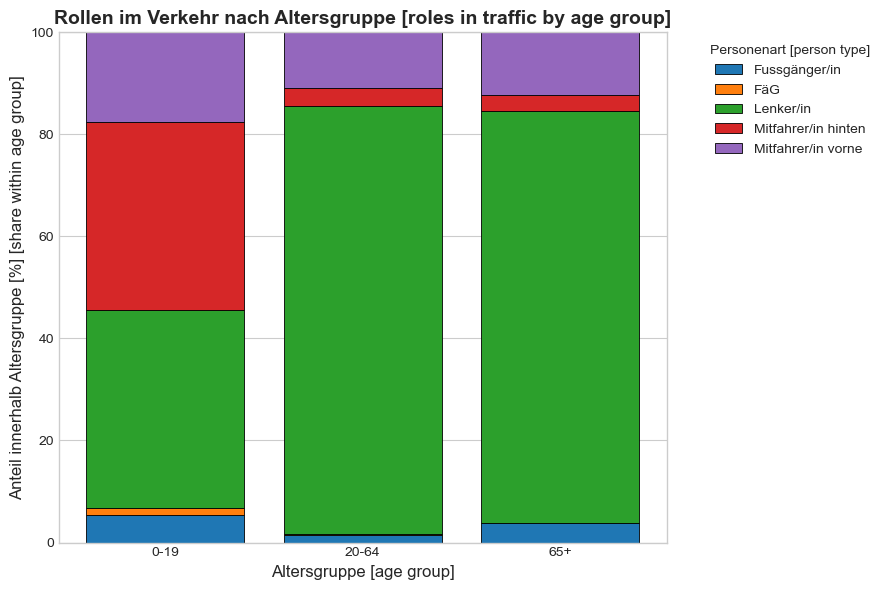

In [63]:
# Keep only rows with known age_group and Personenart
df_roles = df_filt.dropna(subset=["age_group", "Personenart"])

# Compute counts by age_group and Personenart [person type]
role_counts = (
    df_roles
    .groupby(["age_group", "Personenart"])
    .size()
    .reset_index(name="count")
)

# Find top 5 roles overall to keep the plot readable
top_roles = (
    role_counts
    .groupby("Personenart")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(TOP_N_ROLES)
    .index
)

role_counts_top = role_counts[role_counts["Personenart"].isin(top_roles)]

# Convert to percentages within each age group
role_pct = (
    role_counts_top
    .groupby("age_group", group_keys=False)
    .apply(lambda g: g.assign(pct=g["count"] / g["count"].sum() * 100))
)

# Pivot for stacked bar plot
role_pivot = role_pct.pivot(index="age_group", columns="Personenart", values="pct").fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(9, 6))

bottom = np.zeros(len(role_pivot))
x = np.arange(len(role_pivot.index))

for role in role_pivot.columns:
    values = role_pivot[role].values
    ax.bar(
        x,
        values,
        bottom=bottom,
        label=role,
        **PLOT_STYLE
    )
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels(role_pivot.index)

ax.set_xlabel("Altersgruppe [age group]", fontsize=12)
ax.set_ylabel("Anteil innerhalb Altersgruppe [%] [share within age group]", fontsize=12)
ax.set_title("Rollen im Verkehr nach Altersgruppe [roles in traffic by age group]", fontsize=14, fontweight="bold")

ax.legend(title="Personenart [person type]", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

### 5.2 Accident Types: Seniors vs. Adults

Comparison of the most common accident types for seniors (65+) versus adults (20-64). This horizontal bar chart uses abbreviated labels with a legend to show which accident scenarios are over- or under-represented for elderly road users.

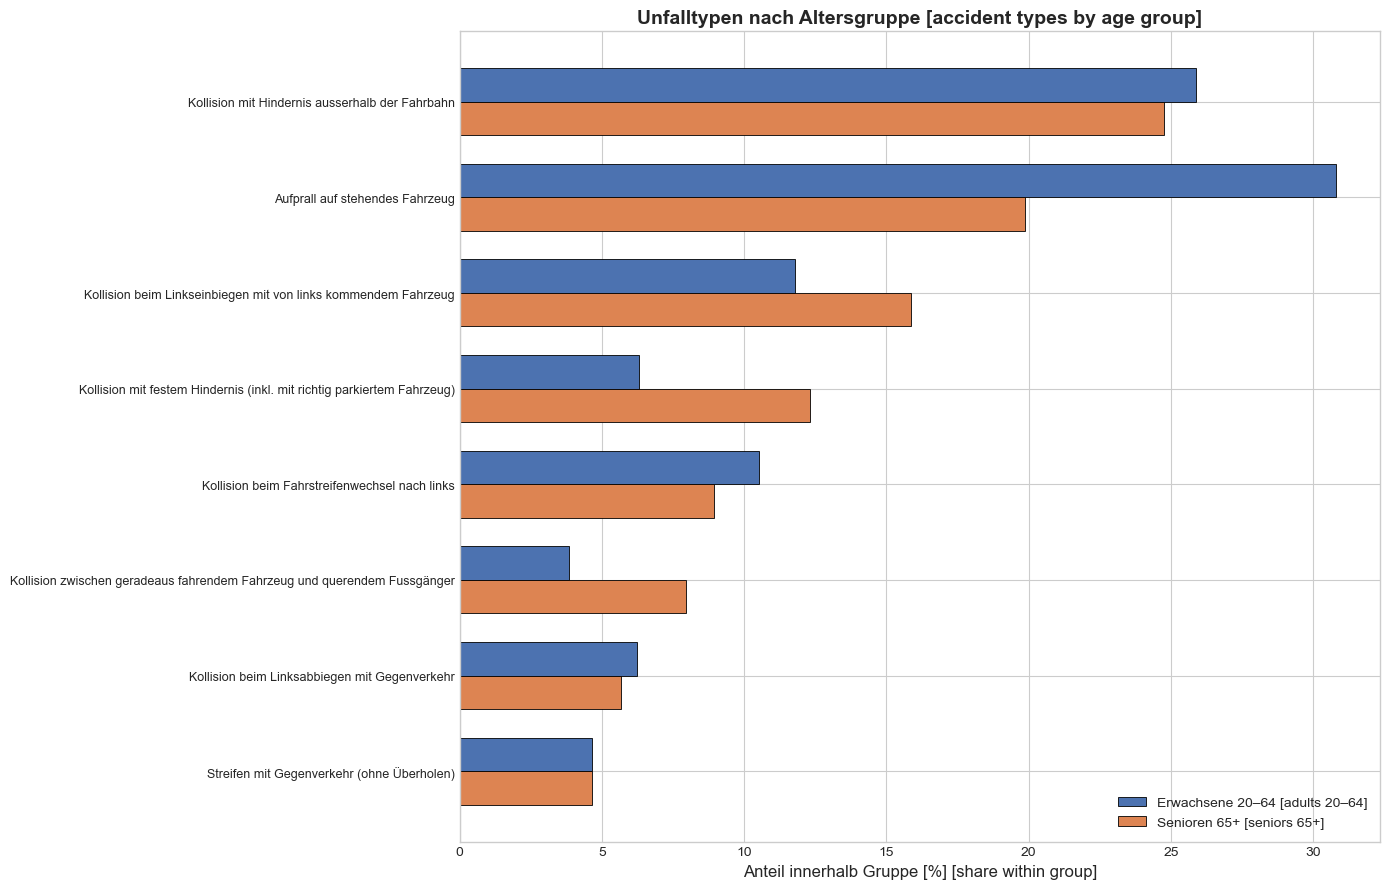


Unfalltypengruppe → Unfalltyp (häufigster) [Accident type group → Most common specific type]:
1. 0
   → Kollision mit Hindernis ausserhalb der Fahrbahn
   Senioren: 29,907 | Erwachsene: 181,373

2. 2
   → Aufprall auf stehendes Fahrzeug
   Senioren: 23,998 | Erwachsene: 215,992

3. 4
   → Kollision beim Linkseinbiegen mit von links kommendem Fahrzeug
   Senioren: 19,158 | Erwachsene: 82,664

4. 7
   → Kollision mit festem Hindernis (inkl. mit richtig parkiertem Fahrzeug)
   Senioren: 14,865 | Erwachsene: 44,267

5. 1
   → Kollision beim Fahrstreifenwechsel nach links
   Senioren: 10,813 | Erwachsene: 73,654

6. 8
   → Kollision zwischen geradeaus fahrendem Fahrzeug und querendem Fussgänger
   Senioren: 9,589 | Erwachsene: 26,830

7. 3
   → Kollision beim Linksabbiegen mit Gegenverkehr
   Senioren: 6,863 | Erwachsene: 43,760

8. 6
   → Streifen mit Gegenverkehr (ohne Überholen)
   Senioren: 5,605 | Erwachsene: 32,513



In [65]:
# Filter data with valid age_group, Unfalltypengruppe, and Unfalltyp
df_types = df_filt.dropna(subset=["age_group", "Unfalltypengruppe", "Unfalltyp"])

adults = df_types[df_types["age_group"] == "20-64"]
seniors = df_types[df_types["age_group"] == "65+"]

# Top 8 accident type groups for seniors based on Unfalltypengruppe
types_senior = seniors["Unfalltypengruppe"].value_counts().head(TOP_N_ACCIDENT_TYPES)
types_index = types_senior.index

senior_pct = types_senior / types_senior.sum() * 100

adult_counts = adults["Unfalltypengruppe"].value_counts().reindex(types_index, fill_value=0)
adult_pct = adult_counts / adult_counts.sum() * 100

# For each Unfalltypengruppe, get the most common Unfalltyp
type_labels = []
for type_gruppe in types_index:
    # Get most common Unfalltyp for this Unfalltypengruppe among seniors
    common_typ = seniors[seniors["Unfalltypengruppe"] == type_gruppe]["Unfalltyp"].mode()
    if len(common_typ) > 0:
        type_labels.append(common_typ.iloc[0])
    else:
        type_labels.append(str(type_gruppe))  # fallback to gruppe name

y = np.arange(len(types_index))

fig, ax = plt.subplots(figsize=(14, 9))

bar_height = 0.35

ax.barh(
    y - bar_height/2,
    adult_pct.values,
    height=bar_height,
    label="Erwachsene 20–64 [adults 20–64]",
    color=COLOR_PALETTE['adults_20_64'],
    **PLOT_STYLE
)

ax.barh(
    y + bar_height/2,
    senior_pct.values,
    height=bar_height,
    label="Senioren 65+ [seniors 65+]",
    color=COLOR_PALETTE['seniors_65plus'],
    **PLOT_STYLE
)

ax.set_yticks(y)
ax.set_yticklabels(type_labels, fontsize=9)

ax.set_xlabel("Anteil innerhalb Gruppe [%] [share within group]", fontsize=12)
ax.set_title("Unfalltypen nach Altersgruppe [accident types by age group]", fontsize=14, fontweight="bold")

ax.legend()
ax.invert_yaxis()  # most frequent at top

plt.tight_layout()
plt.show()

# Print detailed information
print("\nUnfalltypengruppe → Unfalltyp (häufigster) [Accident type group → Most common specific type]:")
print("="*100)
for idx, (type_gruppe, type_label) in enumerate(zip(types_index, type_labels), start=1):
    count_seniors = types_senior[type_gruppe]
    count_adults = adult_counts[type_gruppe]
    print(f"{idx}. {type_gruppe}")
    print(f"   → {type_label}")
    print(f"   Senioren: {count_seniors:,} | Erwachsene: {count_adults:,}")
    print()
print("="*100)

### 5.3 Temporal Evolution: Senior Pedestrians and Cyclists

Line chart showing how accidents involving seniors as pedestrians and cyclists have evolved from 2014 to 2023. Vulnerable road users (pedestrians and cyclists) face higher injury risks, making temporal trends important for policy evaluation.

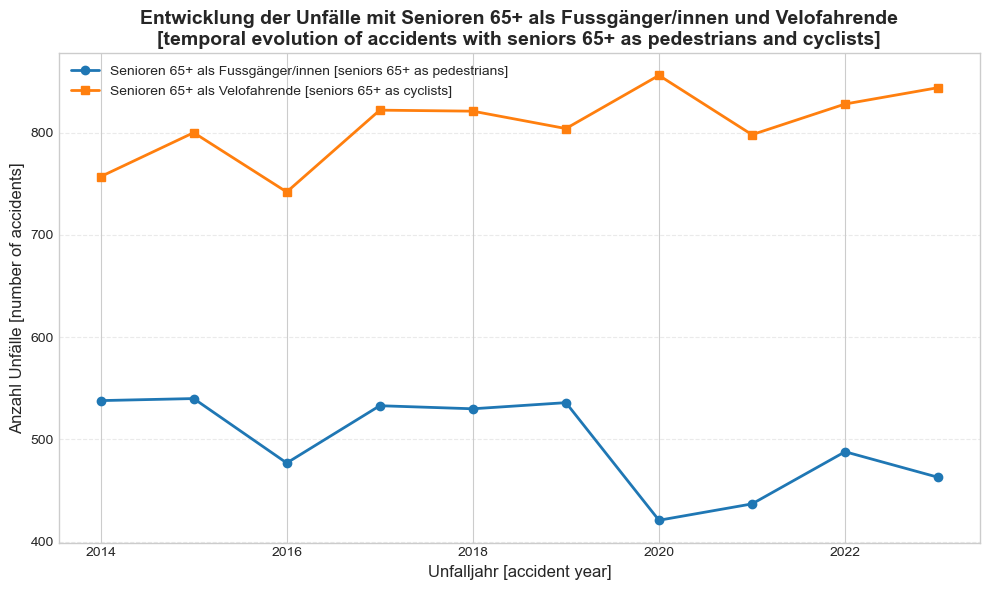

In [39]:
df_modes = df_filt.dropna(subset=["Unfalljahr", "Alter", "Verkehrsteilnahme"])

# Senioren 65+ [seniors 65+]
df_modes_elder = filter_by_age_group(df_modes, min_age=SENIOR_AGE_THRESHOLD)

# Create a lowercased helper column
df_modes_elder["Verkehrsteilnahme_clean"] = df_modes_elder["Verkehrsteilnahme"].str.lower()

# Heuristic classification:
# Fussgänger/in [pedestrian]
is_pedestrian = df_modes_elder["Verkehrsteilnahme_clean"].str.contains("fuss", na=False) | \
                df_modes_elder["Verkehrsteilnahme_clean"].str.contains("fuß", na=False)

# Velo/Fahrrad/Rad [bicycle]
is_cyclist = df_modes_elder["Verkehrsteilnahme_clean"].str.contains("velo", na=False) | \
             df_modes_elder["Verkehrsteilnahme_clean"].str.contains("fahrrad", na=False) | \
             df_modes_elder["Verkehrsteilnahme_clean"].str.contains("rad", na=False)

df_ped = df_modes_elder[is_pedestrian]
df_cyc = df_modes_elder[is_cyclist]

# Count accidents per year
ped_counts = df_ped.groupby("Unfalljahr").size()
cyc_counts = df_cyc.groupby("Unfalljahr").size()

years_sorted = sorted(df_modes_elder["Unfalljahr"].dropna().unique())

# Align both series to the same years (fill missing with 0)
ped_counts = ped_counts.reindex(years_sorted, fill_value=0)
cyc_counts = cyc_counts.reindex(years_sorted, fill_value=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(
    years_sorted,
    ped_counts.values,
    marker="o",
    linewidth=2,
    label="Senioren 65+ als Fussgänger/innen [seniors 65+ as pedestrians]"
)

ax.plot(
    years_sorted,
    cyc_counts.values,
    marker="s",
    linewidth=2,
    label="Senioren 65+ als Velofahrende [seniors 65+ as cyclists]"
)

ax.set_xlabel("Unfalljahr [accident year]", fontsize=12)
ax.set_ylabel("Anzahl Unfälle [number of accidents]", fontsize=12)
ax.set_title("Entwicklung der Unfälle mit Senioren 65+ als Fussgänger/innen und Velofahrende\n[temporal evolution of accidents with seniors 65+ as pedestrians and cyclists]", fontsize=14, fontweight="bold")

ax.grid(True, axis="y", linestyle="--", alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()

### 5.4 Time-of-Day Patterns: When Do Accidents Occur?

Hourly distribution of accidents reveals whether seniors have different activity patterns than adults. Peak accident times may reflect commuting patterns, errand schedules, or visibility issues.

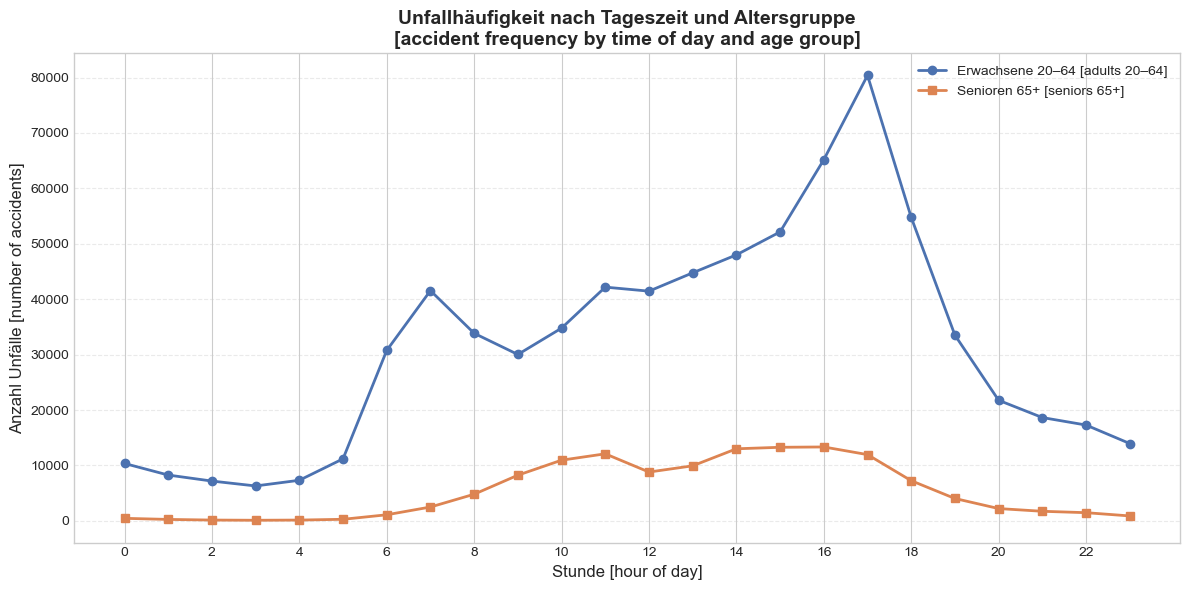


Zusammenfassung [Summary]:
  Erwachsene 20-64: Peak hour = 17:00 with 80,395 accidents
  Senioren 65+: Peak hour = 16:00 with 13,343 accidents


In [40]:
# Filter data with valid hour and age group
df_time = df_filt.dropna(subset=["Stunde", "age_group"])

# Separate adults and seniors
df_adults_time = df_time[df_time["age_group"] == "20-64"]
df_seniors_time = df_time[df_time["age_group"] == "65+"]

# Count accidents by hour for each group
adults_by_hour = df_adults_time.groupby("Stunde").size()
seniors_by_hour = df_seniors_time.groupby("Stunde").size()

# Ensure all hours 0-23 are represented
all_hours = range(24)
adults_by_hour = adults_by_hour.reindex(all_hours, fill_value=0)
seniors_by_hour = seniors_by_hour.reindex(all_hours, fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    all_hours,
    adults_by_hour.values,
    marker='o',
    linewidth=2,
    label="Erwachsene 20–64 [adults 20–64]",
    color=COLOR_PALETTE['adults_20_64']
)

ax.plot(
    all_hours,
    seniors_by_hour.values,
    marker='s',
    linewidth=2,
    label="Senioren 65+ [seniors 65+]",
    color=COLOR_PALETTE['seniors_65plus']
)

ax.set_xlabel("Stunde [hour of day]", fontsize=12)
ax.set_ylabel("Anzahl Unfälle [number of accidents]", fontsize=12)
ax.set_title("Unfallhäufigkeit nach Tageszeit und Altersgruppe\n[accident frequency by time of day and age group]", fontsize=14, fontweight="bold")

ax.set_xticks(range(0, 24, 2))
ax.grid(True, axis="y", linestyle="--", alpha=0.4)
ax.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nZusammenfassung [Summary]:")
print(f"  Erwachsene 20-64: Peak hour = {adults_by_hour.idxmax()}:00 with {adults_by_hour.max():,} accidents")
print(f"  Senioren 65+: Peak hour = {seniors_by_hour.idxmax()}:00 with {seniors_by_hour.max():,} accidents")

### 5.5 Time-of-Day for Severe/Fatal Accidents (Senior Drivers)

Focusing only on severe and fatal accidents involving senior drivers, this plot identifies the most dangerous hours. Different timing patterns may suggest specific risk factors (e.g., rush hour congestion, low-light conditions).

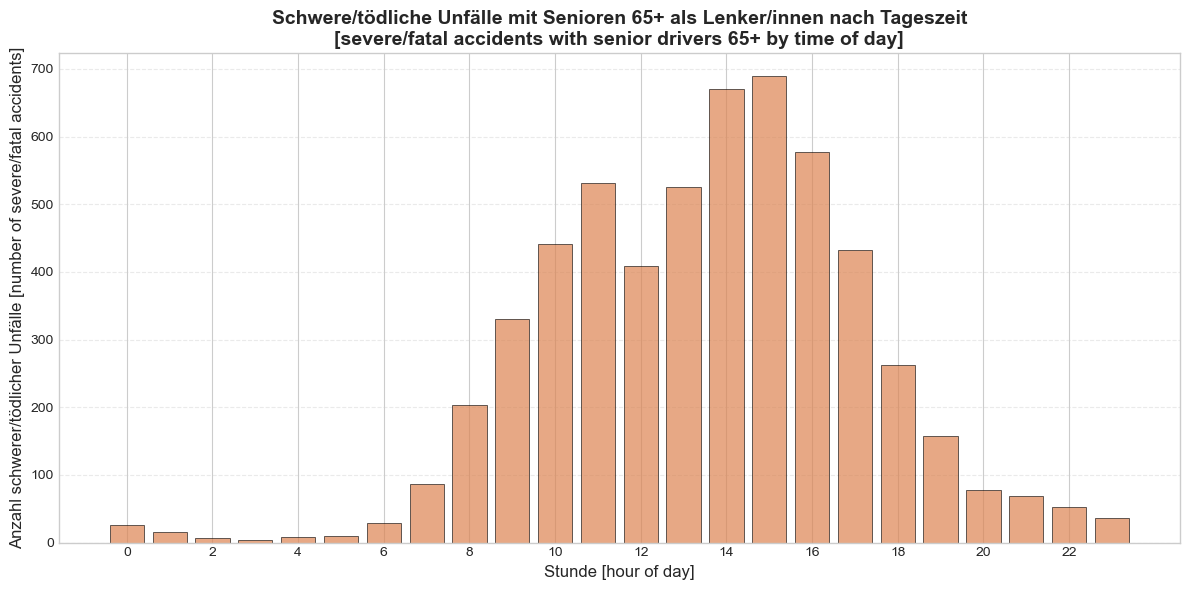


Total severe/fatal accidents with senior drivers: 5,653
Peak hour: 15:00 with 689 accidents


In [41]:
# Filter for severe/fatal accidents with senior drivers
df_severe_time = df_filt[
    (df_filt["Unfallfolgen_Gruppen"].isin(["erheblich / schwer verletzt", "lebensdrohlich / tödlich"])) &
    (df_filt["Personenart"] == "Lenker/in") &
    (df_filt["Alter"] >= SENIOR_AGE_THRESHOLD) &
    (df_filt["Stunde"].notna())
].copy()

# Count by hour
severe_by_hour = df_severe_time.groupby("Stunde").size()
severe_by_hour = severe_by_hour.reindex(range(24), fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(
    range(24),
    severe_by_hour.values,
    color=COLOR_PALETTE['seniors_65plus'],
    alpha=0.7,
    **PLOT_STYLE
)

ax.set_xlabel("Stunde [hour of day]", fontsize=12)
ax.set_ylabel("Anzahl schwerer/tödlicher Unfälle [number of severe/fatal accidents]", fontsize=12)
ax.set_title("Schwere/tödliche Unfälle mit Senioren 65+ als Lenker/innen nach Tageszeit\n[severe/fatal accidents with senior drivers 65+ by time of day]", fontsize=14, fontweight="bold")

ax.set_xticks(range(0, 24, 2))
ax.grid(True, axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

print(f"\nTotal severe/fatal accidents with senior drivers: {severe_by_hour.sum():,}")
print(f"Peak hour: {severe_by_hour.idxmax()}:00 with {severe_by_hour.max()} accidents")

## 6. Environmental and Contextual Factors

Examining how environmental conditions (urban/rural setting, weather, road conditions, lighting) interact with accident severity for elderly road users.

### 6.1 Accident Severity by Urban/Rural Setting

Compare injury severity distributions for seniors versus adults in urban (innerorts) and rural (ausserorts) areas. Rural accidents may be more severe due to higher speeds, while urban accidents may be more frequent.

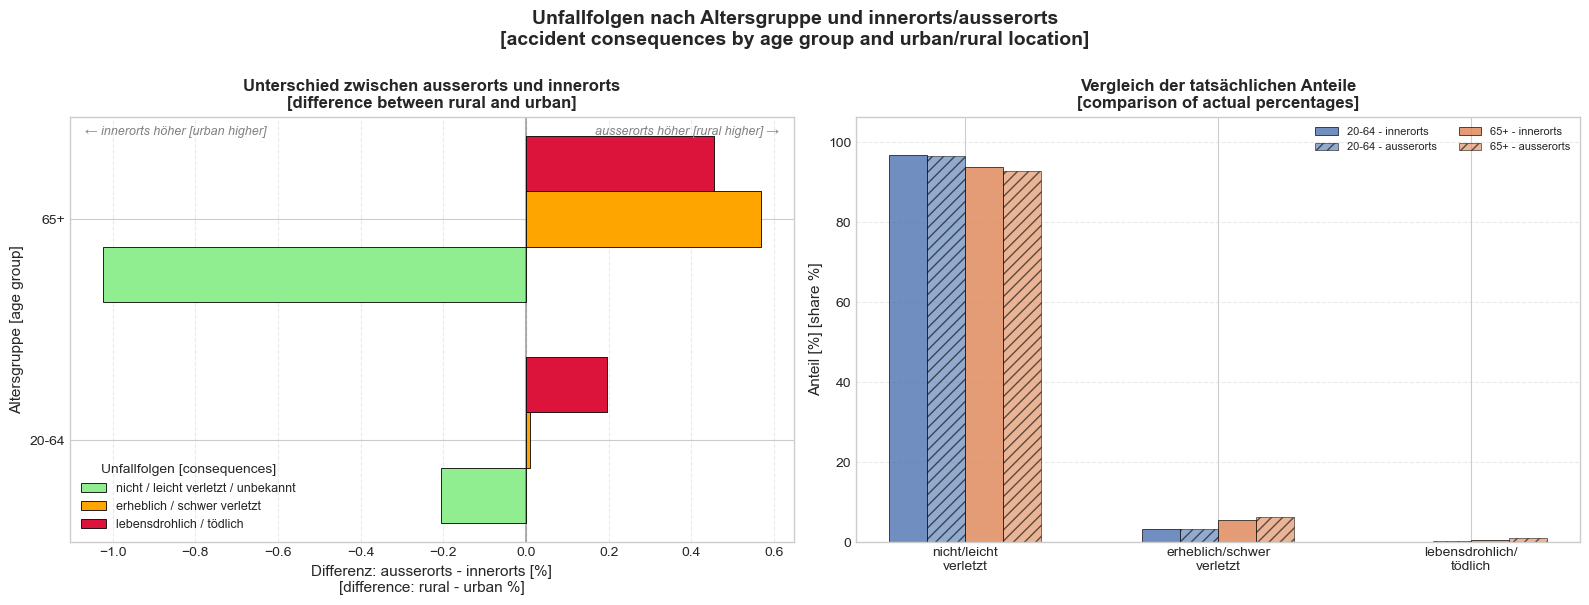


Unfallfolgen nach Altersgruppe und Ort [Accident consequences by age group and location]:
Unfallfolgen_Gruppen           erheblich / schwer verletzt  \
age_group InnerortsAusserorts                                
20-64     ausserorts                                   3.3   
          innerorts                                    3.3   
65+       ausserorts                                   6.3   
          innerorts                                    5.7   

Unfallfolgen_Gruppen           lebensdrohlich / tödlich  \
age_group InnerortsAusserorts                             
20-64     ausserorts                                0.3   
          innerorts                                 0.1   
65+       ausserorts                                1.0   
          innerorts                                 0.5   

Unfallfolgen_Gruppen           nicht / leicht verletzt / unbekannt  
age_group InnerortsAusserorts                                       
20-64     ausserorts                       

In [48]:
# Filter data with valid severity, location, and age group
df_env = df_filt.dropna(subset=["Unfallfolgen_Gruppen", "InnerortsAusserorts", "age_group"])

# Focus on adults and seniors
df_env = df_env[df_env["age_group"].isin(["20-64", "65+"])]

# Create crosstab for each location type
severity_by_group_location = pd.crosstab(
    [df_env["age_group"], df_env["InnerortsAusserorts"]],
    df_env["Unfallfolgen_Gruppen"],
    normalize='index'
) * 100

# Restructure data to calculate urban-rural differences
# Get separate dataframes for urban and rural
urban_data = {}
rural_data = {}

for age_group in ["20-64", "65+"]:
    if (age_group, "innerorts") in severity_by_group_location.index:
        urban_data[age_group] = severity_by_group_location.loc[(age_group, "innerorts")]
    if (age_group, "ausserorts") in severity_by_group_location.index:
        rural_data[age_group] = severity_by_group_location.loc[(age_group, "ausserorts")]

# Calculate differences (Rural - Urban) for each severity and age group
differences = {}
for age_group in ["20-64", "65+"]:
    if age_group in urban_data and age_group in rural_data:
        differences[age_group] = rural_data[age_group] - urban_data[age_group]

# Convert to DataFrame for plotting
diff_df = pd.DataFrame(differences).T

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Diverging bar chart showing differences
severity_order = ["nicht / leicht verletzt / unbekannt", 
                  "erheblich / schwer verletzt", 
                  "lebensdrohlich / tödlich"]
colors_diff = ['#90EE90', '#FFA500', '#DC143C']  # Light green, orange, crimson red

x = np.arange(len(diff_df.index))
width = 0.25

for idx, severity in enumerate(severity_order):
    if severity in diff_df.columns:
        values = diff_df[severity].values
        ax1.barh(
            x + idx * width - width,
            values,
            height=width,
            label=severity,
            color=colors_diff[idx],
            edgecolor='black',
            linewidth=0.6
        )

ax1.axvline(x=0, color='black', linewidth=1.5, linestyle='-', alpha=0.3)
ax1.set_yticks(x)
ax1.set_yticklabels(diff_df.index)
ax1.set_xlabel("Differenz: ausserorts - innerorts [%]\n[difference: rural - urban %]", fontsize=11)
ax1.set_ylabel("Altersgruppe [age group]", fontsize=11)
ax1.set_title("Unterschied zwischen ausserorts und innerorts\n[difference between rural and urban]", 
              fontsize=12, fontweight="bold")
ax1.legend(title="Unfallfolgen [consequences]", loc='best', fontsize=9)
ax1.grid(True, axis="x", linestyle="--", alpha=0.4)

# Add annotations for interpretation
ax1.text(0.02, 0.98, "← innerorts höher [urban higher]", 
         transform=ax1.transAxes, fontsize=9, va='top', ha='left', style='italic', color='gray')
ax1.text(0.98, 0.98, "ausserorts höher [rural higher] →", 
         transform=ax1.transAxes, fontsize=9, va='top', ha='right', style='italic', color='gray')

# Right plot: Grouped comparison of actual percentages
x2 = np.arange(len(severity_order))
width2 = 0.15
age_groups = ["20-64", "65+"]
locations = ["innerorts", "ausserorts"]

bar_positions = []
bar_colors = [COLOR_PALETTE['adults_20_64'], COLOR_PALETTE['seniors_65plus']]
patterns = ['', '///']  # solid for urban, hatched for rural

offset = 0
for age_idx, age_group in enumerate(age_groups):
    for loc_idx, location in enumerate(locations):
        if (age_group, location) in severity_by_group_location.index:
            values = [severity_by_group_location.loc[(age_group, location), sev] 
                     if sev in severity_by_group_location.columns else 0 
                     for sev in severity_order]
            
            pos = x2 + offset
            bars = ax2.bar(
                pos,
                values,
                width=width2,
                label=f"{age_group} - {location}",
                color=bar_colors[age_idx],
                alpha=0.8 if location == "innerorts" else 0.6,
                edgecolor='black',
                linewidth=0.6,
                hatch=patterns[loc_idx]
            )
            offset += width2

ax2.set_xticks(x2 + width2 * 1.5)
ax2.set_xticklabels(['nicht/leicht\nverletzt', 'erheblich/schwer\nverletzt', 'lebensdrohlich/\ntödlich'], 
                     fontsize=10)
ax2.set_ylabel("Anteil [%] [share %]", fontsize=11)
ax2.set_title("Vergleich der tatsächlichen Anteile\n[comparison of actual percentages]", 
              fontsize=12, fontweight="bold")
ax2.legend(loc='upper right', fontsize=8, ncol=2)
ax2.grid(True, axis="y", linestyle="--", alpha=0.4)
ax2.set_ylim(0, max(severity_by_group_location.max()) * 1.1)

plt.suptitle("Unfallfolgen nach Altersgruppe und innerorts/ausserorts\n[accident consequences by age group and urban/rural location]", 
             fontsize=14, fontweight="bold", y=1.00)
plt.tight_layout()
plt.show()

# Print summary table with differences
print("\nUnfallfolgen nach Altersgruppe und Ort [Accident consequences by age group and location]:")
print("="*90)
print(severity_by_group_location.round(1))
print("\n" + "="*90)
print("\nDifferenzen (ausserorts - innerorts) [Differences (rural - urban)]:")
print("="*90)
print(diff_df.round(1))
print("="*90)
print("\nInterpretation:")
print("  Positive Werte: ausserorts höher [Positive values: higher in rural areas]")
print("  Negative Werte: innerorts höher [Negative values: higher in urban areas]")

### 6.2 Severe/Fatal Accidents by Weather and Road Conditions (Seniors 65+)

For seniors only, examine how weather (Witterung) and road surface conditions (Strassenzustand) are distributed among severe and fatal accidents. Adverse conditions may disproportionately affect older drivers.

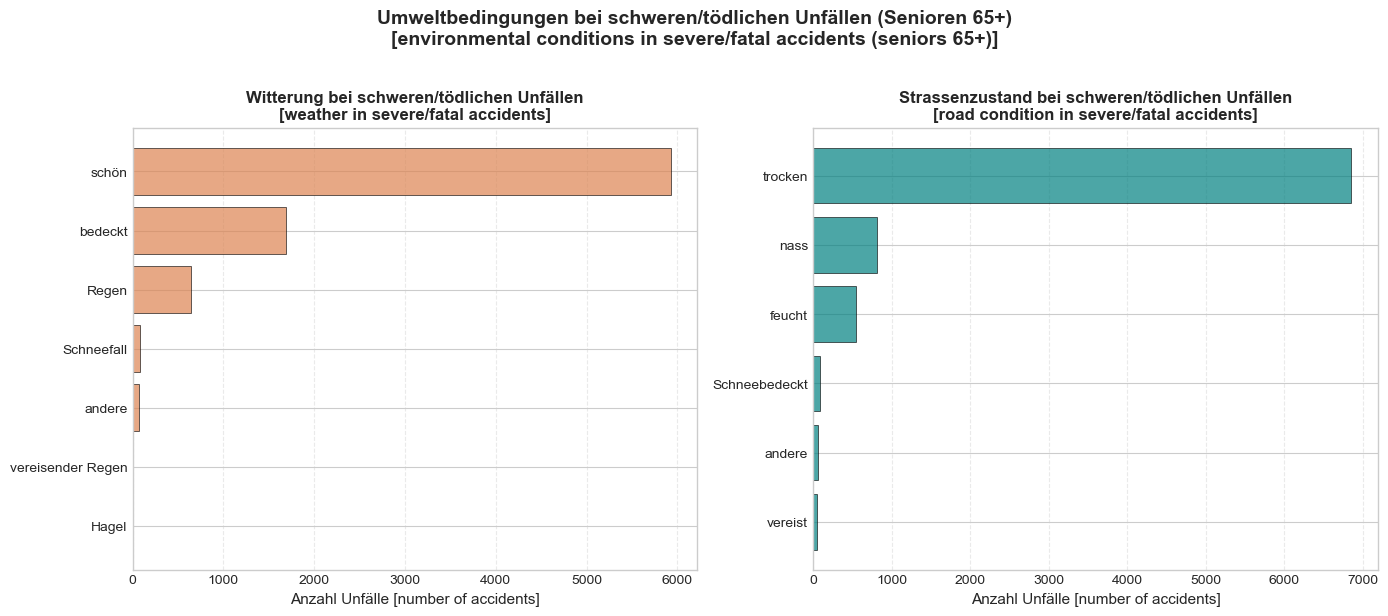


Total severe/fatal accidents with seniors 65+: 8,419


In [49]:
# Filter for severe/fatal accidents with seniors
df_severe_env = df_filt[
    (df_filt["Unfallfolgen_Gruppen"].isin(["erheblich / schwer verletzt", "lebensdrohlich / tödlich"])) &
    (df_filt["Alter"] >= SENIOR_AGE_THRESHOLD)
].copy()

# Weather conditions
weather_counts = df_severe_env["Witterung"].value_counts().head(8)

# Road conditions
road_counts = df_severe_env["Strassenzustand"].value_counts().head(8)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Weather plot
ax1.barh(
    range(len(weather_counts)),
    weather_counts.values,
    color=COLOR_PALETTE['seniors_65plus'],
    alpha=0.7,
    **PLOT_STYLE
)
ax1.set_yticks(range(len(weather_counts)))
ax1.set_yticklabels(weather_counts.index, fontsize=10)
ax1.set_xlabel("Anzahl Unfälle [number of accidents]", fontsize=11)
ax1.set_title("Witterung bei schweren/tödlichen Unfällen\n[weather in severe/fatal accidents]", fontsize=12, fontweight="bold")
ax1.invert_yaxis()
ax1.grid(True, axis="x", linestyle="--", alpha=0.4)

# Road condition plot
ax2.barh(
    range(len(road_counts)),
    road_counts.values,
    color=COLOR_PALETTE['age_70_74'],
    alpha=0.7,
    **PLOT_STYLE
)
ax2.set_yticks(range(len(road_counts)))
ax2.set_yticklabels(road_counts.index, fontsize=10)
ax2.set_xlabel("Anzahl Unfälle [number of accidents]", fontsize=11)
ax2.set_title("Strassenzustand bei schweren/tödlichen Unfällen\n[road condition in severe/fatal accidents]", fontsize=12, fontweight="bold")
ax2.invert_yaxis()
ax2.grid(True, axis="x", linestyle="--", alpha=0.4)

plt.suptitle("Umweltbedingungen bei schweren/tödlichen Unfällen (Senioren 65+)\n[environmental conditions in severe/fatal accidents (seniors 65+)]", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

print(f"\nTotal severe/fatal accidents with seniors 65+: {len(df_severe_env):,}")

### 6.2b Environmental Conditions: Age Group Comparison

Compare how weather and road conditions affect severe/fatal accidents across all age groups. This reveals whether adverse environmental conditions have a disproportionate impact on younger vs. older road users.

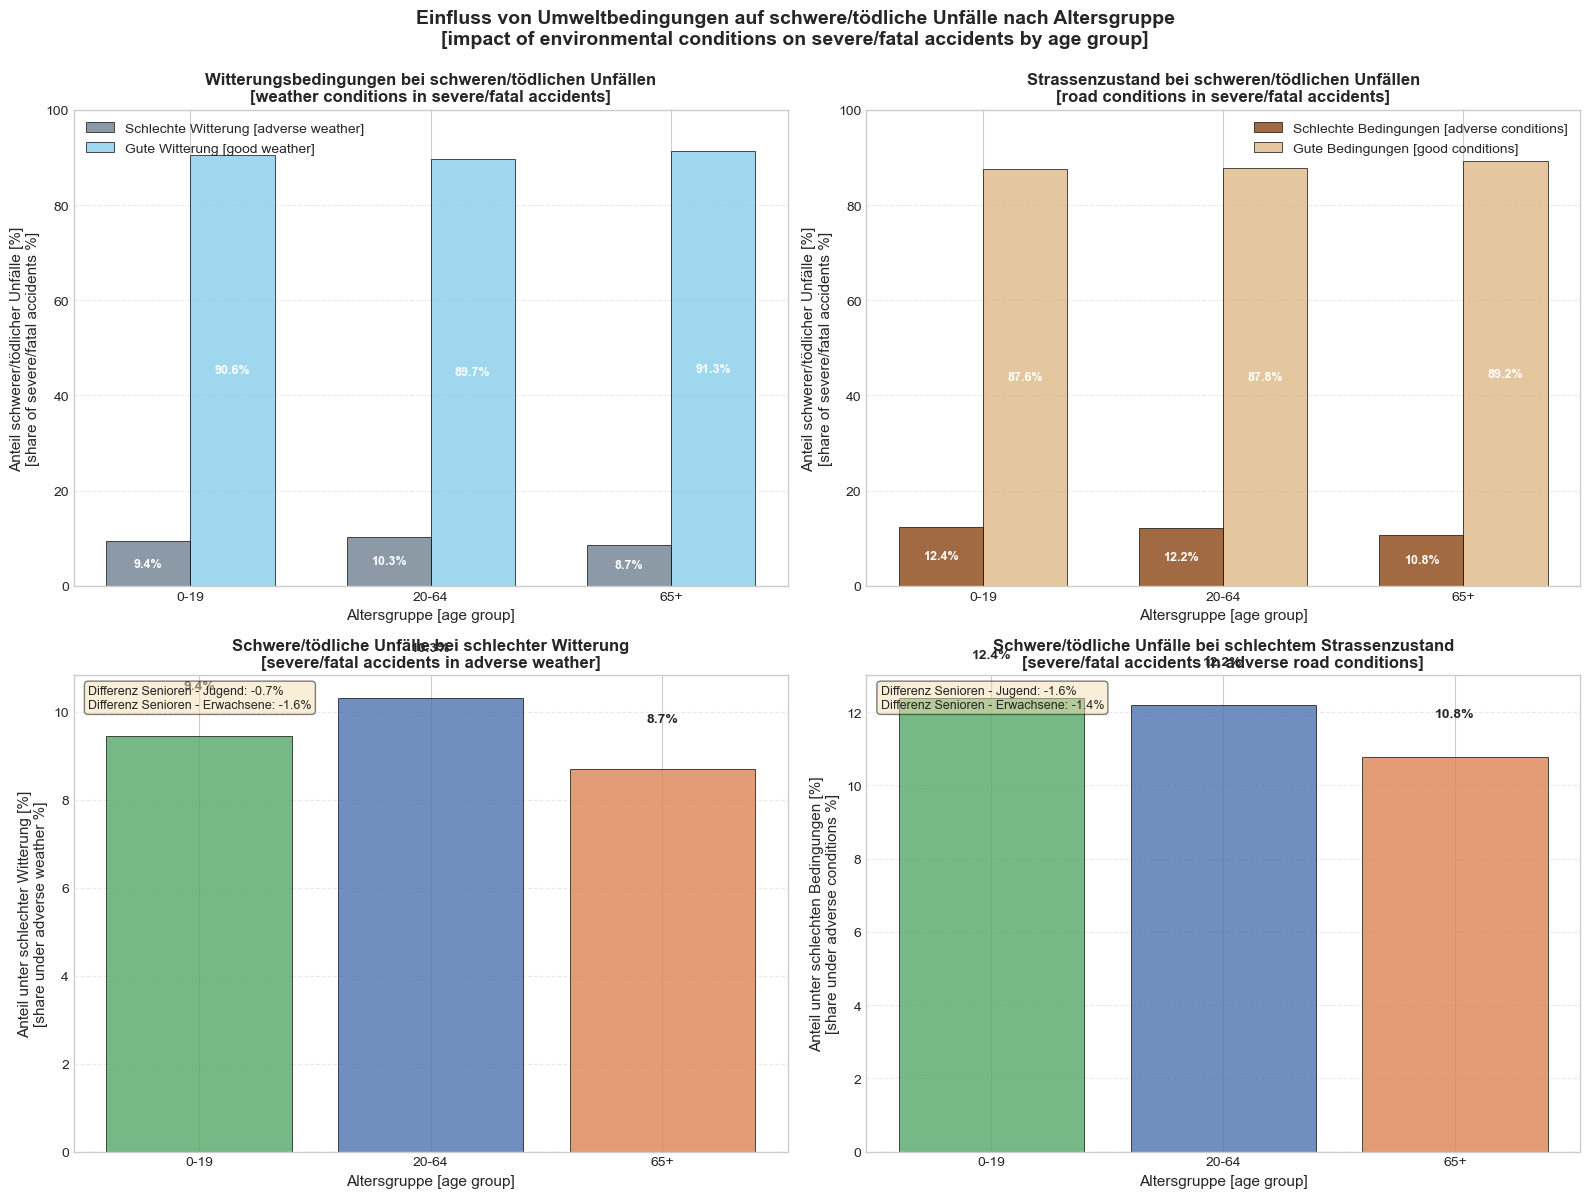


WITTERUNGSBEDINGUNGEN [WEATHER CONDITIONS]

0-19:
  Total schwere/tödliche Unfälle [severe/fatal accidents]: 4,917
  Schlechte Witterung [adverse weather]: 9.4%
  Gute Witterung [good weather]: 90.6%

20-64:
  Total schwere/tödliche Unfälle [severe/fatal accidents]: 25,918
  Schlechte Witterung [adverse weather]: 10.3%
  Gute Witterung [good weather]: 89.7%

65+:
  Total schwere/tödliche Unfälle [severe/fatal accidents]: 8,419
  Schlechte Witterung [adverse weather]: 8.7%
  Gute Witterung [good weather]: 91.3%

STRASSENZUSTAND [ROAD CONDITIONS]

0-19:
  Total schwere/tödliche Unfälle [severe/fatal accidents]: 4,917
  Schlechte Bedingungen [adverse conditions]: 12.4%
  Gute Bedingungen [good conditions]: 87.6%

20-64:
  Total schwere/tödliche Unfälle [severe/fatal accidents]: 25,918
  Schlechte Bedingungen [adverse conditions]: 12.2%
  Gute Bedingungen [good conditions]: 87.8%

65+:
  Total schwere/tödliche Unfälle [severe/fatal accidents]: 8,419
  Schlechte Bedingungen [adverse condit

In [50]:
# Filter for severe/fatal accidents across all age groups
df_env_age_compare = df_filt[
    (df_filt["Unfallfolgen_Gruppen"].isin(["erheblich / schwer verletzt", "lebensdrohlich / tödlich"])) &
    (df_filt["age_group"].notna())
].copy()

# Define adverse conditions
adverse_weather = ["Regen", "Schneefall", "Hagel", "Nebel"]
adverse_road = ["nass", "Schnee", "Eis, Frost", "verschmutzt"]

# Calculate percentage of severe/fatal accidents under adverse conditions by age group
weather_analysis = []
road_analysis = []

for age_group in AGE_LABELS:
    df_age = df_env_age_compare[df_env_age_compare["age_group"] == age_group]
    total = len(df_age)
    
    if total > 0:
        # Weather analysis
        adverse_weather_count = df_age[df_age["Witterung"].isin(adverse_weather)].shape[0]
        weather_pct = (adverse_weather_count / total) * 100
        weather_analysis.append({
            'age_group': age_group,
            'adverse_pct': weather_pct,
            'good_pct': 100 - weather_pct,
            'total': total
        })
        
        # Road condition analysis
        adverse_road_count = df_age[df_age["Strassenzustand"].str.contains('|'.join(adverse_road), case=False, na=False)].shape[0]
        road_pct = (adverse_road_count / total) * 100
        road_analysis.append({
            'age_group': age_group,
            'adverse_pct': road_pct,
            'good_pct': 100 - road_pct,
            'total': total
        })

weather_df = pd.DataFrame(weather_analysis)
road_df = pd.DataFrame(road_analysis)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top left: Weather conditions comparison
ax1 = axes[0, 0]
x = np.arange(len(weather_df))
width = 0.35

bars1 = ax1.bar(x - width/2, weather_df['adverse_pct'], width, 
                label='Schlechte Witterung [adverse weather]',
                color='#708090', alpha=0.8, **PLOT_STYLE)
bars2 = ax1.bar(x + width/2, weather_df['good_pct'], width,
                label='Gute Witterung [good weather]',
                color='#87CEEB', alpha=0.8, **PLOT_STYLE)

ax1.set_xlabel("Altersgruppe [age group]", fontsize=11)
ax1.set_ylabel("Anteil schwerer/tödlicher Unfälle [%]\n[share of severe/fatal accidents %]", fontsize=11)
ax1.set_title("Witterungsbedingungen bei schweren/tödlichen Unfällen\n[weather conditions in severe/fatal accidents]", 
              fontsize=12, fontweight="bold")
ax1.set_xticks(x)
ax1.set_xticklabels(weather_df['age_group'])
ax1.legend()
ax1.grid(True, axis="y", linestyle="--", alpha=0.4)
ax1.set_ylim(0, 100)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 3:  # Only show if bar is visible enough
            ax1.text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{height:.1f}%',
                    ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# Top right: Road conditions comparison
ax2 = axes[0, 1]
bars3 = ax2.bar(x - width/2, road_df['adverse_pct'], width,
                label='Schlechte Bedingungen [adverse conditions]',
                color='#8B4513', alpha=0.8, **PLOT_STYLE)
bars4 = ax2.bar(x + width/2, road_df['good_pct'], width,
                label='Gute Bedingungen [good conditions]',
                color='#DEB887', alpha=0.8, **PLOT_STYLE)

ax2.set_xlabel("Altersgruppe [age group]", fontsize=11)
ax2.set_ylabel("Anteil schwerer/tödlicher Unfälle [%]\n[share of severe/fatal accidents %]", fontsize=11)
ax2.set_title("Strassenzustand bei schweren/tödlichen Unfällen\n[road conditions in severe/fatal accidents]",
              fontsize=12, fontweight="bold")
ax2.set_xticks(x)
ax2.set_xticklabels(road_df['age_group'])
ax2.legend()
ax2.grid(True, axis="y", linestyle="--", alpha=0.4)
ax2.set_ylim(0, 100)

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height > 3:
            ax2.text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{height:.1f}%',
                    ha='center', va='center', fontsize=9, fontweight='bold', color='white')

# Bottom left: Adverse weather only - direct comparison
ax3 = axes[1, 0]
bars5 = ax3.bar(x, weather_df['adverse_pct'], 
                color=[COLOR_PALETTE['youth_0_19'], COLOR_PALETTE['adults_20_64'], COLOR_PALETTE['seniors_65plus']],
                alpha=0.8, **PLOT_STYLE)

ax3.set_xlabel("Altersgruppe [age group]", fontsize=11)
ax3.set_ylabel("Anteil unter schlechter Witterung [%]\n[share under adverse weather %]", fontsize=11)
ax3.set_title("Schwere/tödliche Unfälle bei schlechter Witterung\n[severe/fatal accidents in adverse weather]",
              fontsize=12, fontweight="bold")
ax3.set_xticks(x)
ax3.set_xticklabels(weather_df['age_group'])
ax3.grid(True, axis="y", linestyle="--", alpha=0.4)

# Add value labels and highlight differences
for i, bar in enumerate(bars5):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Calculate and display relative differences
youth_pct = weather_df.iloc[0]['adverse_pct']
adult_pct = weather_df.iloc[1]['adverse_pct']
senior_pct = weather_df.iloc[2]['adverse_pct']
diff_youth_senior = senior_pct - youth_pct
diff_adult_senior = senior_pct - adult_pct

ax3.text(0.02, 0.98, 
         f"Differenz Senioren - Jugend: {diff_youth_senior:+.1f}%\n"
         f"Differenz Senioren - Erwachsene: {diff_adult_senior:+.1f}%",
         transform=ax3.transAxes, fontsize=9, va='top', ha='left',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Bottom right: Adverse road conditions only - direct comparison
ax4 = axes[1, 1]
bars6 = ax4.bar(x, road_df['adverse_pct'],
                color=[COLOR_PALETTE['youth_0_19'], COLOR_PALETTE['adults_20_64'], COLOR_PALETTE['seniors_65plus']],
                alpha=0.8, **PLOT_STYLE)

ax4.set_xlabel("Altersgruppe [age group]", fontsize=11)
ax4.set_ylabel("Anteil unter schlechten Bedingungen [%]\n[share under adverse conditions %]", fontsize=11)
ax4.set_title("Schwere/tödliche Unfälle bei schlechtem Strassenzustand\n[severe/fatal accidents in adverse road conditions]",
              fontsize=12, fontweight="bold")
ax4.set_xticks(x)
ax4.set_xticklabels(road_df['age_group'])
ax4.grid(True, axis="y", linestyle="--", alpha=0.4)

for i, bar in enumerate(bars6):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Calculate relative differences for road conditions
diff_road_youth_senior = road_df.iloc[2]['adverse_pct'] - road_df.iloc[0]['adverse_pct']
diff_road_adult_senior = road_df.iloc[2]['adverse_pct'] - road_df.iloc[1]['adverse_pct']

ax4.text(0.02, 0.98,
         f"Differenz Senioren - Jugend: {diff_road_youth_senior:+.1f}%\n"
         f"Differenz Senioren - Erwachsene: {diff_road_adult_senior:+.1f}%",
         transform=ax4.transAxes, fontsize=9, va='top', ha='left',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle("Einfluss von Umweltbedingungen auf schwere/tödliche Unfälle nach Altersgruppe\n"
             "[impact of environmental conditions on severe/fatal accidents by age group]",
             fontsize=14, fontweight="bold", y=0.995)
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*90)
print("WITTERUNGSBEDINGUNGEN [WEATHER CONDITIONS]")
print("="*90)
for idx, row in weather_df.iterrows():
    print(f"\n{row['age_group']}:")
    print(f"  Total schwere/tödliche Unfälle [severe/fatal accidents]: {row['total']:,}")
    print(f"  Schlechte Witterung [adverse weather]: {row['adverse_pct']:.1f}%")
    print(f"  Gute Witterung [good weather]: {row['good_pct']:.1f}%")

print("\n" + "="*90)
print("STRASSENZUSTAND [ROAD CONDITIONS]")
print("="*90)
for idx, row in road_df.iterrows():
    print(f"\n{row['age_group']}:")
    print(f"  Total schwere/tödliche Unfälle [severe/fatal accidents]: {row['total']:,}")
    print(f"  Schlechte Bedingungen [adverse conditions]: {row['adverse_pct']:.1f}%")
    print(f"  Gute Bedingungen [good conditions]: {row['good_pct']:.1f}%")

print("\n" + "="*90)
print("INTERPRETATION")
print("="*90)
print(f"Witterung - Senioren vs. Jugend: {diff_youth_senior:+.1f} Prozentpunkte")
print(f"Witterung - Senioren vs. Erwachsene: {diff_adult_senior:+.1f} Prozentpunkte")
print(f"Strassenzustand - Senioren vs. Jugend: {diff_road_youth_senior:+.1f} Prozentpunkte")
print(f"Strassenzustand - Senioren vs. Erwachsene: {diff_road_adult_senior:+.1f} Prozentpunkte")
print("\nPositive Werte = höherer Anteil bei Senioren [Positive values = higher proportion for seniors]")
print("Negative Werte = höherer Anteil bei jüngeren Gruppen [Negative values = higher proportion for younger groups]")
print("="*90)

### 6.3 Light Conditions in Severe/Fatal Accidents by Age Group

Compare light conditions (Lichtverhältnis) for severe/fatal accidents across age groups. Poor lighting may pose greater challenges for elderly drivers due to age-related vision changes.

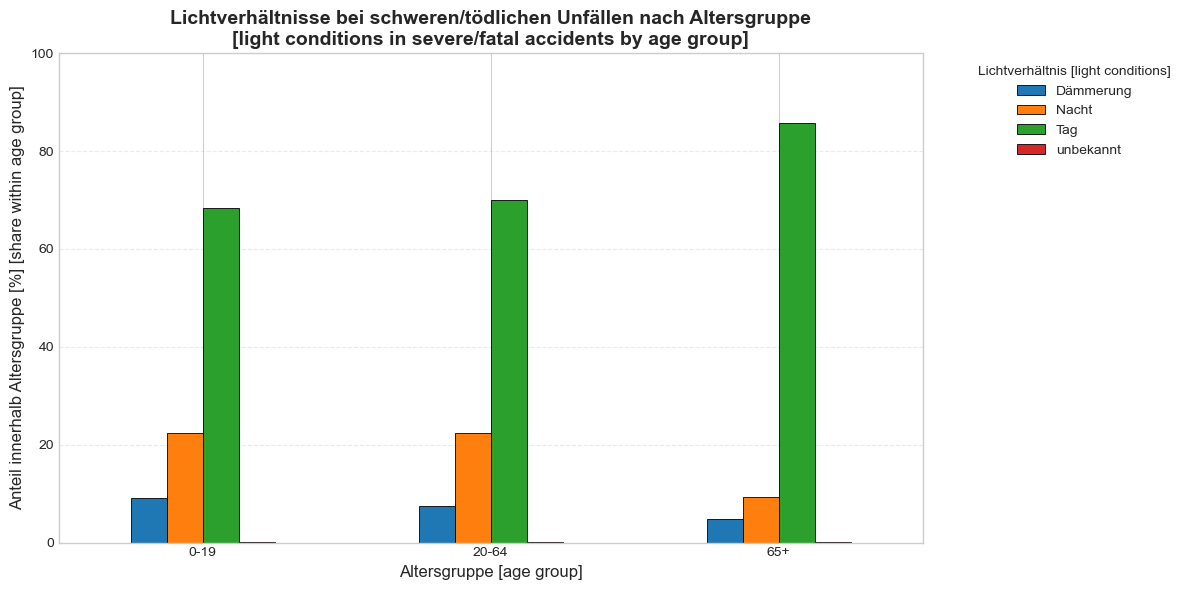


Lichtverhältnisse bei schweren/tödlichen Unfällen [%]:
Lichtverhältnis  Dämmerung  Nacht   Tag  unbekannt
age_group                                         
0-19                   9.1   22.4  68.4        0.1
20-64                  7.6   22.4  69.9        0.1
65+                    4.9    9.3  85.7        0.1


In [44]:
# Filter for severe/fatal accidents with valid light conditions and age group
df_light_severe = df_filt[
    (df_filt["Unfallfolgen_Gruppen"].isin(["erheblich / schwer verletzt", "lebensdrohlich / tödlich"])) &
    (df_filt["Lichtverhältnis"].notna()) &
    (df_filt["age_group"].notna())
].copy()

# Create crosstab normalized by age group
light_by_age = pd.crosstab(
    df_light_severe["age_group"],
    df_light_severe["Lichtverhältnis"],
    normalize='index'
) * 100

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

light_by_age.plot(
    kind='bar',
    ax=ax,
    edgecolor='black',
    linewidth=0.6
)

ax.set_xlabel("Altersgruppe [age group]", fontsize=12)
ax.set_ylabel("Anteil innerhalb Altersgruppe [%] [share within age group]", fontsize=12)
ax.set_title("Lichtverhältnisse bei schweren/tödlichen Unfällen nach Altersgruppe\n[light conditions in severe/fatal accidents by age group]", fontsize=14, fontweight="bold")

ax.legend(title="Lichtverhältnis [light conditions]", bbox_to_anchor=(1.05, 1), loc="upper left")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(True, axis="y", linestyle="--", alpha=0.4)
ax.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Print summary
print("\nLichtverhältnisse bei schweren/tödlichen Unfällen [%]:")
print("="*80)
print(light_by_age.round(1))
print("="*80)

### 6.4 Regional Comparison: Senior Driver Accidents by Canton

Compare accident frequencies involving senior drivers across Swiss cantons, showing the top 10 cantons with the most incidents. A before/after 2019 comparison may reveal policy or demographic trends.

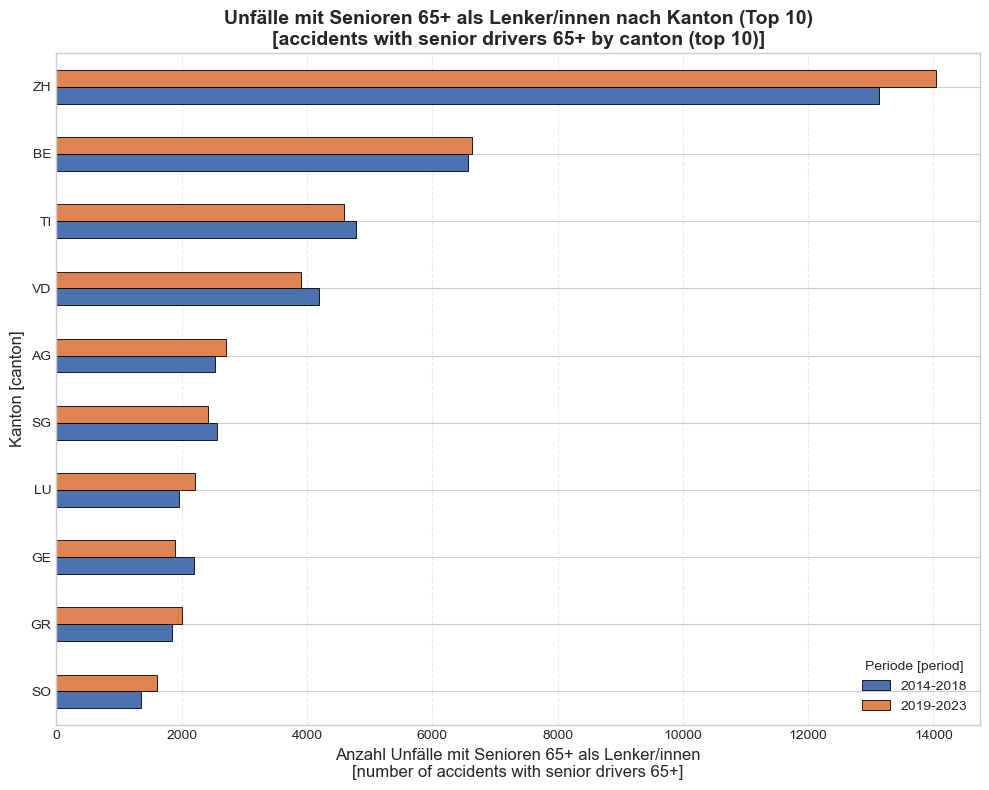


Top 10 Kantone mit Unfällen von Senioren 65+ als Lenker/innen:
Periode       2014-2018  2019-2023  Total
Unfallkanton                             
ZH                13135      14041  27176
BE                 6574       6638  13212
TI                 4782       4587   9369
VD                 4200       3898   8098
AG                 2539       2705   5244
SG                 2564       2419   4983
LU                 1958       2212   4170
GE                 2193       1896   4089
GR                 1845       2009   3854
SO                 1343       1613   2956

Total accidents with senior drivers in top 10 cantons: 83,151


In [45]:
# Filter for senior drivers with valid canton and year
df_canton = df_filt[
    (df_filt["Personenart"] == "Lenker/in") &
    (df_filt["Alter"] >= SENIOR_AGE_THRESHOLD) &
    (df_filt["Unfallkanton"].notna()) &
    (df_filt["Unfalljahr"].notna())
].copy()

# Create time period: before 2019 vs 2019 onwards
df_canton["Periode"] = df_canton["Unfalljahr"].apply(lambda x: "2014-2018" if x < 2019 else "2019-2023")

# Get top 10 cantons by total accidents
top_cantons = df_canton["Unfallkanton"].value_counts().head(TOP_N_CANTONS).index

df_canton_top = df_canton[df_canton["Unfallkanton"].isin(top_cantons)]

# Create crosstab
canton_period = pd.crosstab(df_canton_top["Unfallkanton"], df_canton_top["Periode"])

# Sort by total
canton_period["Total"] = canton_period.sum(axis=1)
canton_period = canton_period.sort_values("Total", ascending=True)
canton_period = canton_period.drop("Total", axis=1)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

canton_period.plot(
    kind='barh',
    ax=ax,
    color=[COLOR_PALETTE['adults_20_64'], COLOR_PALETTE['seniors_65plus']],
    edgecolor='black',
    linewidth=0.6
)

ax.set_xlabel("Anzahl Unfälle mit Senioren 65+ als Lenker/innen\n[number of accidents with senior drivers 65+]", fontsize=12)
ax.set_ylabel("Kanton [canton]", fontsize=12)
ax.set_title("Unfälle mit Senioren 65+ als Lenker/innen nach Kanton (Top 10)\n[accidents with senior drivers 65+ by canton (top 10)]", fontsize=14, fontweight="bold")

ax.legend(title="Periode [period]", loc="lower right")
ax.grid(True, axis="x", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTop 10 Kantone mit Unfällen von Senioren 65+ als Lenker/innen:")
print("="*70)
canton_summary = canton_period.copy()
canton_summary["Total"] = canton_summary.sum(axis=1)
canton_summary = canton_summary.sort_values("Total", ascending=False)
print(canton_summary)
print("="*70)
print(f"\nTotal accidents with senior drivers in top 10 cantons: {canton_summary['Total'].sum():,}")

## 7. Responsibility Analysis: Senior Drivers in Severe/Fatal Accidents

Examining the proportion of severe/fatal accidents where senior drivers are identified as the main responsible party (Hauptverursacher), broken down by age sub-groups (65-69, 70-74, 75+) over time.

In [46]:
# ---------------------------------------------
# Filter: only severe or fatal accidents
# ---------------------------------------------
# Assuming you already have df_filt and Unfallfolgen_Gruppen created with your mapping
severe_mask = df_filt["Unfallfolgen_Gruppen"].isin([
    "erheblich / schwer verletzt",      # severely / seriously injured
    "lebensdrohlich / tödlich"         # life-threatening / fatal
])

df_severe = df_filt[severe_mask].copy()

# Keep only seniors as Lenker/in [drivers] and non-missing years + age
df_severe = df_severe[
    (df_severe["Personenart"] == "Lenker/in") &   # Lenker/in [driver]
    df_severe["Unfalljahr"].notna() &
    df_severe["Alter"].notna()
].copy()

# Age groups for drivers: 65–69, 70–74, 75+
age_groups = {
    "65-69": (65, 69),
    "70-74": (70, 74),
    "75+":   (75, 200)
}

years = sorted(df_severe["Unfalljahr"].unique())

# Prepare data structure: for each age group & year, % ja / nein
resp_share_severe = {g: {"ja": [], "nein": []} for g in age_groups}

for year in years:
    df_y = df_severe[df_severe["Unfalljahr"] == year]

    for g, (a_min, a_max) in age_groups.items():
        df_group = df_y[(df_y["Alter"] >= a_min) & (df_y["Alter"] <= a_max)]

        total = len(df_group)
        if total == 0:
            resp_share_severe[g]["ja"].append(0)
            resp_share_severe[g]["nein"].append(0)
            continue

        ja_count = len(df_group[df_group["Hauptverursacher"] == "ja"])
        nein_count = len(df_group[df_group["Hauptverursacher"] == "nein"])

        resp_share_severe[g]["ja"].append(ja_count * 100 / total)
        resp_share_severe[g]["nein"].append(nein_count * 100 / total)

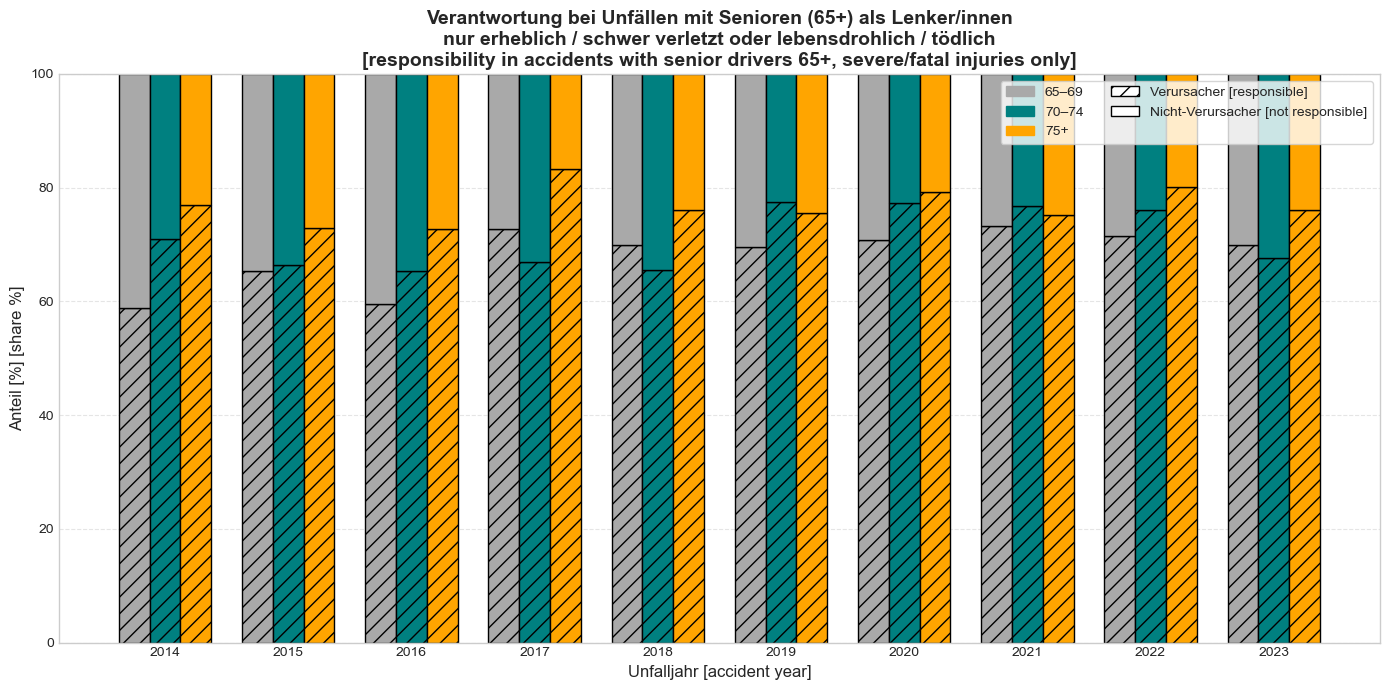

In [47]:
x = np.arange(len(years))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 7))

# Base colors for age groups from our palette
colors = {
    "65-69": COLOR_PALETTE['age_65_69'],
    "70-74": COLOR_PALETTE['age_70_74'],
    "75+":   COLOR_PALETTE['age_75plus']
}

# One unified hatch pattern for Verursacher [responsible]
hatch_pattern = "//"

offsets = [-width, 0, width]

for (g, off) in zip(age_groups.keys(), offsets):

    ja_vals   = resp_share_severe[g]["ja"]
    nein_vals = resp_share_severe[g]["nein"]

    # Verursacher (hatched) [responsible]
    ax.bar(
        x + off,
        ja_vals,
        width,
        color=colors[g],
        edgecolor="black",
        hatch=hatch_pattern
    )

    # Nicht-Verursacher (solid) [not responsible]
    ax.bar(
        x + off,
        nein_vals,
        width,
        bottom=ja_vals,
        color=colors[g],
        edgecolor="black"
    )

# Labels & axes
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.set_xlabel("Unfalljahr [accident year]", fontsize=12)
ax.set_ylabel("Anteil [%] [share %]", fontsize=12)
ax.set_title(
    "Verantwortung bei Unfällen mit Senioren (65+) als Lenker/innen\n"
    "nur erheblich / schwer verletzt oder lebensdrohlich / tödlich\n"
    "[responsibility in accidents with senior drivers 65+, severe/fatal injuries only]",
    fontsize=14,
    fontweight="bold"
)

ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# ---- CUSTOM CLEAN LEGEND ----
import matplotlib.patches as mpatches

# Age-group patches (solid)
lg_age = [
    mpatches.Patch(color=colors["65-69"], label="65–69"),
    mpatches.Patch(color=colors["70-74"], label="70–74"),
    mpatches.Patch(color=colors["75+"],   label="75+"),
]

# Responsibility patches (white background)
lg_resp = [
    mpatches.Patch(facecolor="white", edgecolor="black",
                   hatch=hatch_pattern, label="Verursacher [responsible]"),
    mpatches.Patch(facecolor="white", edgecolor="black",
                   label="Nicht-Verursacher [not responsible]")
]

ax.legend(handles=lg_age + lg_resp,
          ncol=2, fontsize=10, frameon=True)

plt.tight_layout()
plt.show()

## 8. Summary and Key Findings

This analysis of Swiss road accident data (2014–2023) reveals several important patterns regarding elderly road users:

**Participation Patterns:**
- Seniors (65+) have distinct traffic participation patterns compared to younger age groups, with different distributions across driver, passenger, pedestrian, and cyclist roles.

**Accident Types:**
- Certain accident type groups are more prevalent among seniors, suggesting specific risk scenarios that could be targeted for interventions.
- The frequency tables show which maneuvers or situations most commonly lead to accidents involving elderly road users.

**Temporal Patterns:**
- Time-of-day analysis reveals when seniors are most active on roads and when severe accidents occur, which may differ from adult patterns.
- Trends over the 2014-2023 period show evolution of accidents involving senior pedestrians and cyclists.

**Environmental Context:**
- Accident severity varies by urban/rural setting, with different risk profiles for seniors in different environments.
- Weather, road conditions, and lighting play important roles in severe/fatal accidents involving seniors.
- Age-related vision changes may make certain light conditions particularly challenging for older drivers.

**Regional Variations:**
- Canton-level analysis shows geographic concentration of accidents with senior drivers, with notable differences between earlier (2014-2018) and later (2019-2023) periods.

**Responsibility:**
- The proportion of severe/fatal accidents where senior drivers are identified as responsible varies by age sub-group (65-69, 70-74, 75+), providing insights for targeted safety programs.

**Implications for Policy:**
- These findings can inform targeted road safety interventions, infrastructure improvements, and educational programs specifically designed for elderly road users.
- Understanding the specific contexts (time, location, conditions) where seniors face higher risks enables more effective prevention strategies.